## Image generation using RBMs in JAX

In [3]:
from rbmax.model import RBMEnsemble
from rbmax.data_utils import load_mnist_train, denormalize_mnist_image
from PIL import Image
import jax.numpy as jnp
import matplotlib.pyplot as plt

### Utilities

In [4]:
def sample_mnist_images(raw_input_batch, rbms, return_raw_arrays: bool=True):
    formatted = raw_input_batch[None, ...] if len(raw_input_batch.shape) < 3 else raw_input_batch
    h = rbms.encode(formatted)
    v = rbms.generate(h)
    if return_raw_arrays:
        return jnp.array([
            denormalize_mnist_image(v[m,i]) 
            for m in range(rbms.ensemble_size) 
            for i in range(raw_input_batch.shape[0])
        ])
    ims = [Image.fromarray(denormalize_mnist_image(v[0,i]), 'L') for i in range(len(v))]
    return ims

def display_images(ground_truth, generated, title="Ground-truth VS reconstructed MNIST images"):
    assert len(ground_truth) == len(generated), "Supply one generated image for each ground-truth example"
    rows = 2
    cols = ground_truth.shape[0]
    num_images = rows * cols
    half = num_images // 2

    fig, axes = plt.subplots(rows, cols, figsize=(1.5*cols, 2*rows))
    plt.title(title, loc='center', y=3.0)
    for i in range(num_images):
        ax = axes[i//cols, i%cols]
        if i < num_images // 2:
            if i% cols == 0:
                ax.set_title("Ground truth")
            im = ground_truth[i].reshape(28,28)
        else:
            if i% cols == 0:
                ax.set_title("Reconstructed")
            im = generated[i - half]
        ax.imshow(im, cmap='gray')
        ax.axis('off')


### Training

We'll generate and display some images each epoch

In [5]:
data, _ = load_mnist_train(use_labels = False, normalize = True)

rbms = RBMEnsemble(
    ensemble_size=1,
    data_size=784, # 28 * 28 for MNIST
    hidden_size=200,
)

# Try encoding and then generating an image batch before training -- should be noise
recon_untrained = sample_mnist_images(data[:5], rbms)

# Now initialize with visible biases set to the (transformed) mean of the training data, as in
# https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf
rbms = RBMEnsemble(
    ensemble_size=1,
    data_size=784, # 28 * 28 for MNIST
    hidden_size=200,
    init_data=data,
)
# Try encoding and then generating an image batch before training 
# biases alone drive output to a blurry average of the dataset
recon_biases_initialized = sample_mnist_images(data[:5], rbms)

rbms = rbms.train_cd(
    data,
    batch_size=16,
    n=1,
    lr=1e-2,
    epochs=20
)

recon_5_epochs = sample_mnist_images(data[:5], rbms)

Epoch 0, Energy [-469.0641]

Epoch 1, Energy [-1697.7616]

Epoch 2, Energy [-2236.5713]

Epoch 3, Energy [-2604.9355]

Epoch 4, Energy [-2904.262]

Epoch 5, Energy [-3165.5637]

Epoch 6, Energy [-3406.9448]

Epoch 7, Energy [-3632.0527]

Epoch 8, Energy [-3843.75]

Epoch 9, Energy [-4036.9888]

Epoch 10, Energy [-4219.953]

Epoch 11, Energy [-4383.761]

Epoch 12, Energy [-4539.3164]

Epoch 13, Energy [-4673.1436]

Epoch 14, Energy [-4793.1187]

Epoch 15, Energy [-4900.927]

Epoch 16, Energy [-4993.9844]

Epoch 17, Energy [-5074.555]

Epoch 18, Energy [-5156.736]

Epoch 19, Energy [-5224.368]

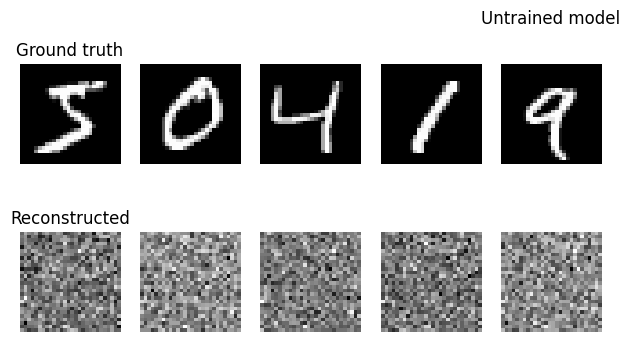

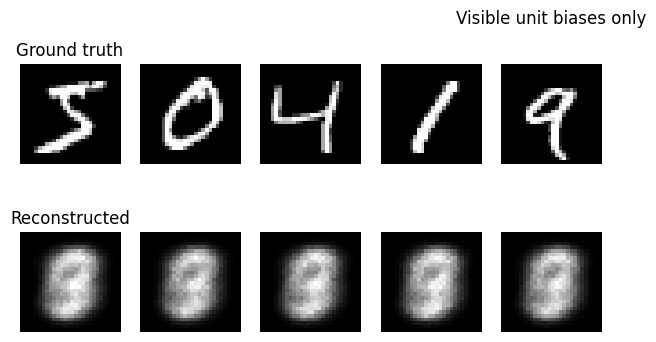

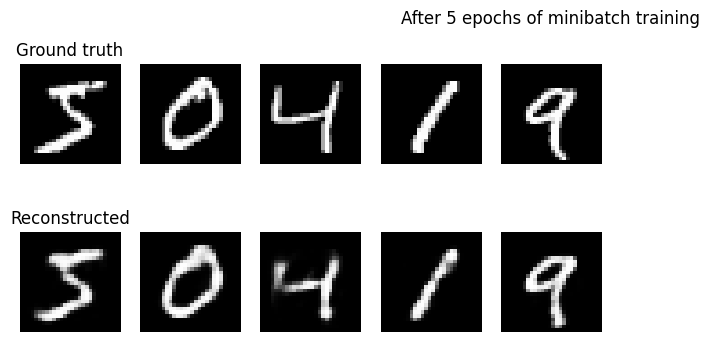

In [7]:
display_images(data[:5], recon_untrained, title="Untrained model")
display_images(data[:5], recon_biases_initialized, title="Visible unit biases only")
display_images(data[:5], recon_5_epochs, title="After 5 epochs of minibatch training")

